## Time Series E2E Exercise

The goal of this mini-project is to practice what you have learned at each stage of the pipeline throughout the time series module. You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful).

Use the data from this kaggle competition: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

There will not be a presentation, but be sure and have a final notebook that someone could quickly review to see what you found. Don't forget the planning stage! Practice all the techniques and best practices you have been taught and have been using in each module thus far. 

Create a notebook within your existing time series exercises repository.

Submit a link to your final notebook.


### Project Planning

1. Pick a city or state from the Berkeley earth climate change earth surface temperature data set
2. Acquire the data
3. Explore the unclean data to determine the needed steps to take in the data preparation 
4. Prepare / clean / tidy the data for splitting and exploration
5. Pick a reasonable splitting point and split into train /validate / test datasets
6. Explore the train dataset
    - Look at trends and cycles over time
    - Visualize changes over time
    - Visualize a seasonal cycle
7. Build at least 3 Models (Simple Average, Moving Average, Holt's Linear Trend, ect)
8. Evaluate Models, adjust hyperparameters and pick best model to evaluate on test
9. Conclusions / Takeaways / Next Steps
 
### Executive Summary 

- There is clear seasonality of 12 months in this data
- Most of the models had a similar RMSE scores with an RMSE of 8.0 to 10.0
- Using previous year's cycle to predict average temperatures worked the best with an RMSE of 2.2 


In [1]:
# Imports

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
from math import sqrt 
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
import project

In [2]:
plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

## Data Wrangling (Acquire / Prepare)

 - Acquire Berkeley earth climate change earth surface temperature data set
 - Only extracted for data in Charlotte, NC
 - Renamed columns
 - Interpolated missing values
 - Date was an object column, changed it to datetime
 - Set the date as the index
 - Made a year and month column based off of the date column
 - Set it for years 1900 to 2013
 - Return a clean pandas DataFrame ready for exploration

In [3]:
df = project.get_temp_data()

In [4]:
df = project.prepare_temp_data(df)

In [5]:
df

,avg_temp,AverageTemperatureUncertainty,city,country,Latitude,Longitude,year,month
date,,,,,,,,
1900-01-01,5.002,0.586,Charlotte,United States,34.56N,81.73W,1900,1
1900-02-01,4.723,0.546,Charlotte,United States,34.56N,81.73W,1900,2
1900-03-01,9.482,0.394,Charlotte,United States,34.56N,81.73W,1900,3
1900-04-01,15.443,0.240,Charlotte,United States,34.56N,81.73W,1900,4
1900-05-01,20.436,0.394,Charlotte,United States,34.56N,81.73W,1900,5
...,...,...,...,...,...,...,...,...
2013-05-01,19.652,0.217,Charlotte,United States,34.56N,81.73W,2013,5
2013-06-01,25.199,0.199,Charlotte,United States,34.56N,81.73W,2013,6
2013-07-01,26.005,0.210,Charlotte,United States,34.56N,81.73W,2013,7


In [6]:
df.describe()

,avg_temp,AverageTemperatureUncertainty,year,month
count,1365.000000,1365.000000,1365.000000,1365.000000
mean,16.265848,0.294730,1956.375824,6.490110
std,7.605914,0.115237,32.848986,3.450436
min,-0.399000,0.070000,1900.000000,1.000000
25%,9.425000,0.217000,1928.000000,3.000000
50%,16.244000,0.279000,1956.000000,6.000000
75%,23.867000,0.344000,1985.000000,9.000000
max,29.438000,1.067000,2013.000000,12.000000


In [7]:
df.index.min(), df.index.max()

(Timestamp('1900-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

In [8]:
df.index.nunique()

1365

## Explore

<AxesSubplot:xlabel='year'>

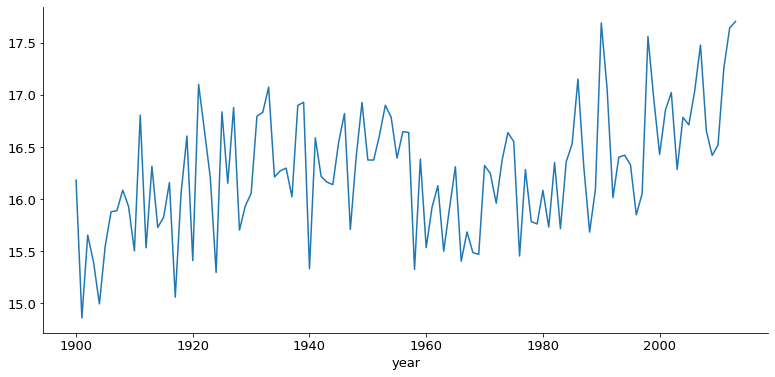

In [9]:
# how does average temperature change over the years?

df.groupby('year').avg_temp.mean().plot()

<AxesSubplot:xlabel='month'>

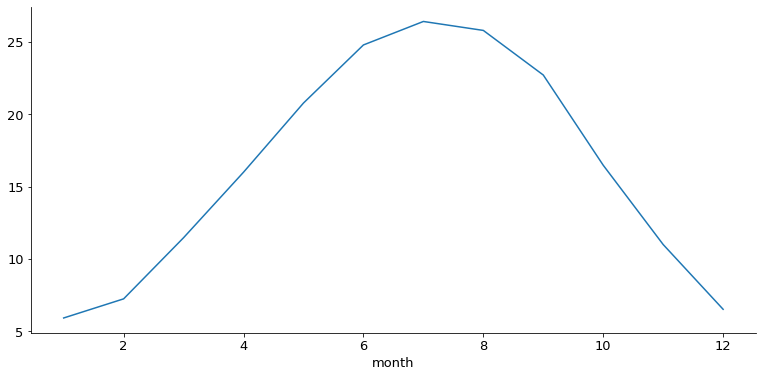

In [10]:
# how does average temperature change over the months within a year?

df.groupby('month').avg_temp.mean().plot()

<AxesSubplot:>

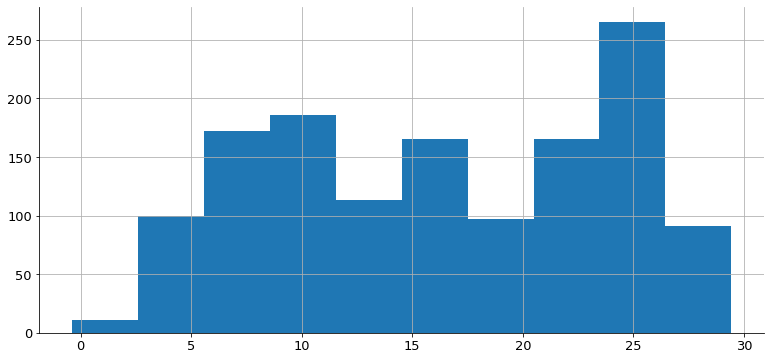

In [11]:
# average temp distribution

df.avg_temp.hist()

<AxesSubplot:xlabel='year'>

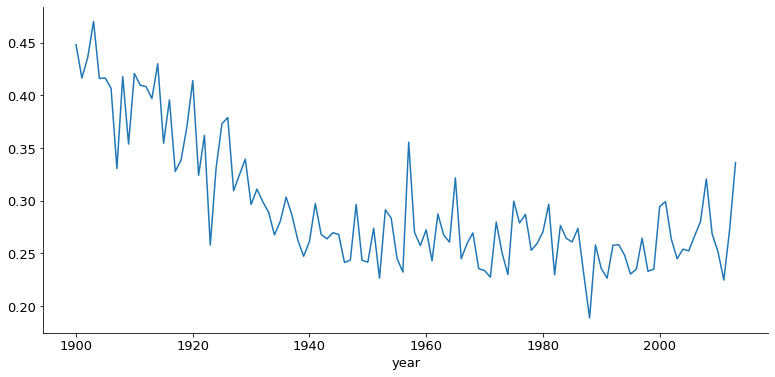

In [12]:
# how does the unvertainty change over all of these years?

df.groupby('year').AverageTemperatureUncertainty.mean().plot()

**Takeaways:**
 - Average Temperature appears to be increasing each year, had a slight dip in the late 50's, early 60's
 - Uncertainty was higher in the early 1900's 
 - Coldest months are at the beginning and the end of the year. Hottest months are June thru August

Splitting my data, going to focus on average temperatures. Also dropping unneccessary columns

In [13]:
# Only going to look at date, and average temperature

df = df[['avg_temp']]

In [14]:
# 50% of data goes to train

train_size = int(len(df)*0.5)

In [15]:
# 30% goes to validate

validate_size = int(len(df)*0.3)

In [16]:
# test gets 20% 

test_size = int(len(df)-train_size - validate_size)

In [17]:
# establishing that the end of the validate set is the length of train size and validate size combined

validate_end_index = train_size + validate_size

In [18]:
# train

train = df[:train_size]

# validate

validate = df[train_size:validate_end_index]

# test

test = df[validate_end_index:]

In [19]:
# is len of train + validate + test == lenght of entire dataframe

print(len(train) + len(validate) + len(test) == len(df))

True


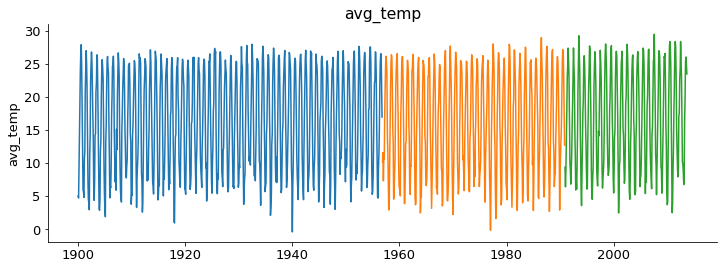

In [20]:
# let's have a look at our data and its splits

for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    
    plt.ylabel(col)
    plt.title(col)

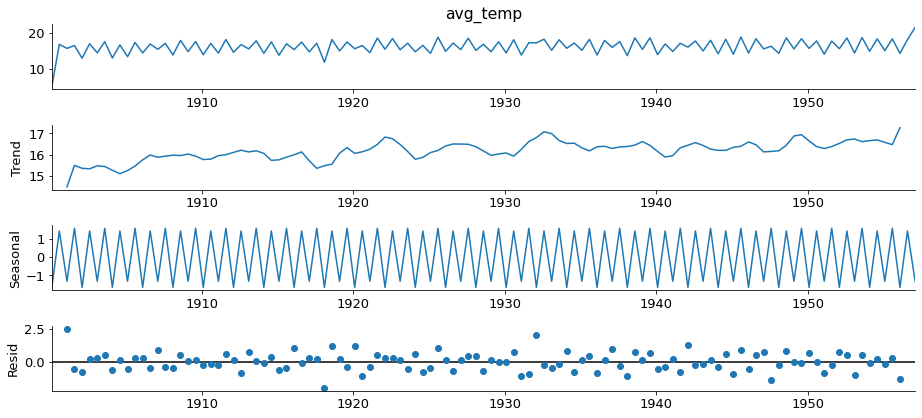

In [21]:
# seasonal decomposition - 6 months

sm.tsa.seasonal_decompose(train.avg_temp.resample('6M').mean()).plot()
None

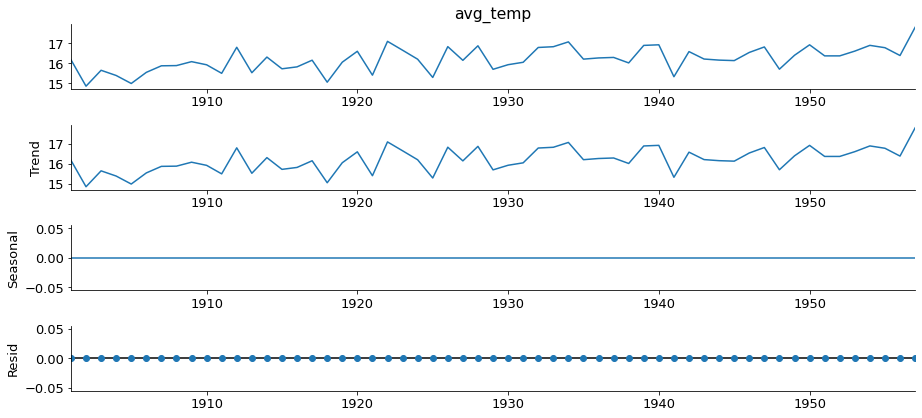

In [22]:
# seasonal decomposition - 1 year

sm.tsa.seasonal_decompose(train.avg_temp.resample('Y').mean()).plot()
None

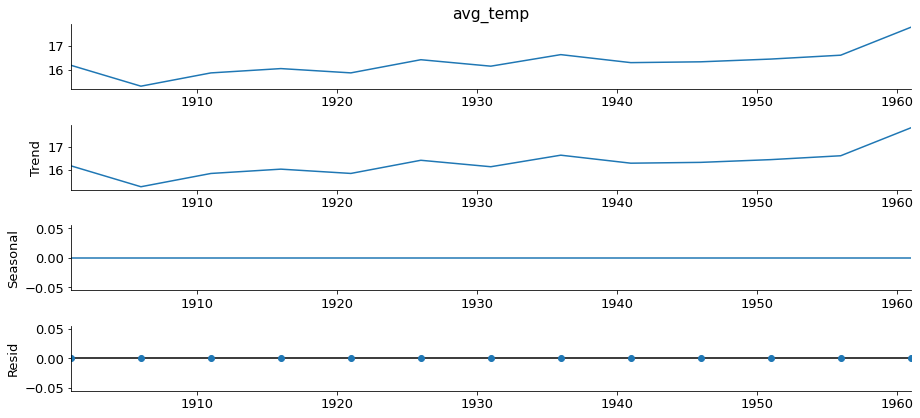

In [23]:
# seasonal decomposition - 5 year

sm.tsa.seasonal_decompose(train.avg_temp.resample('5Y').mean()).plot()
None

In [24]:
# further exploration with average temperature

y = train.avg_temp

<AxesSubplot:xlabel='date'>

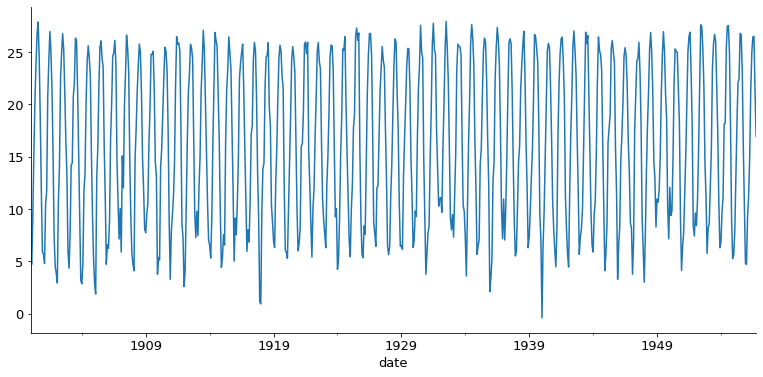

In [25]:
# looking at our training data

y.plot()

Seems that the temperatures are fairly consistent

<AxesSubplot:xlabel='date'>

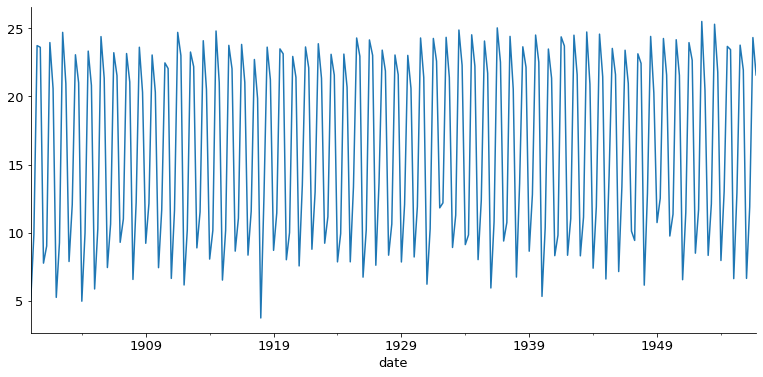

In [26]:
y.resample('3M').mean().plot()

temps still fairly consistent

<AxesSubplot:xlabel='date'>

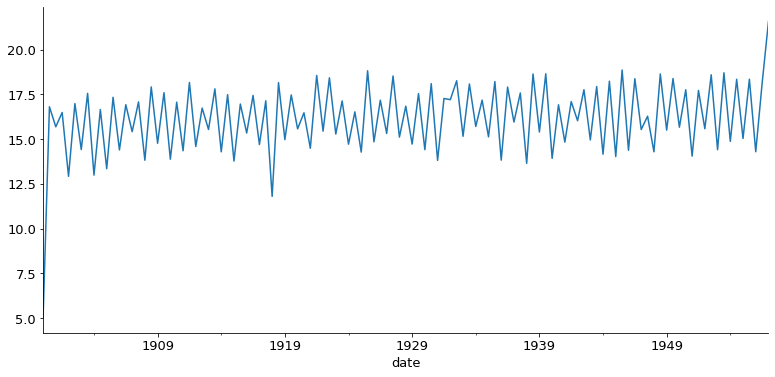

In [27]:
y.resample('6M').mean().plot()

Still consistent, noticing a slight upward trend

<AxesSubplot:xlabel='date'>

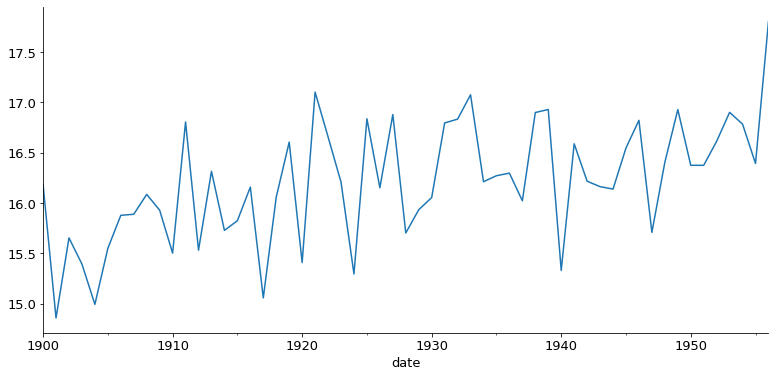

In [28]:
y.resample('Y').mean().plot()

Overall upward trend over the years, but there's some extreme peaks and valleys. 

<AxesSubplot:xlabel='date'>

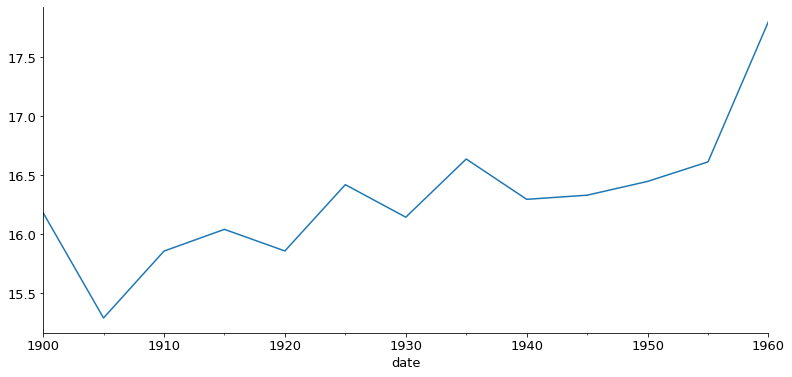

In [29]:
y.resample('5Y').mean().plot()

see upward treand better with smoothing out peaks and valleys

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

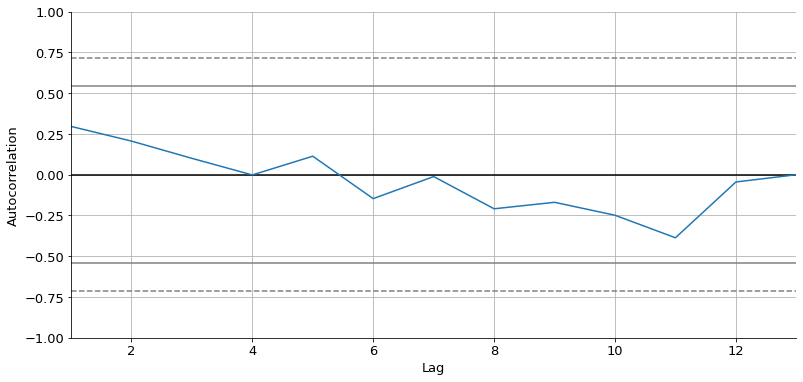

In [30]:
# auto correlation

pd.plotting.autocorrelation_plot(y.resample('5Y').mean())

<AxesSubplot:xlabel='date'>

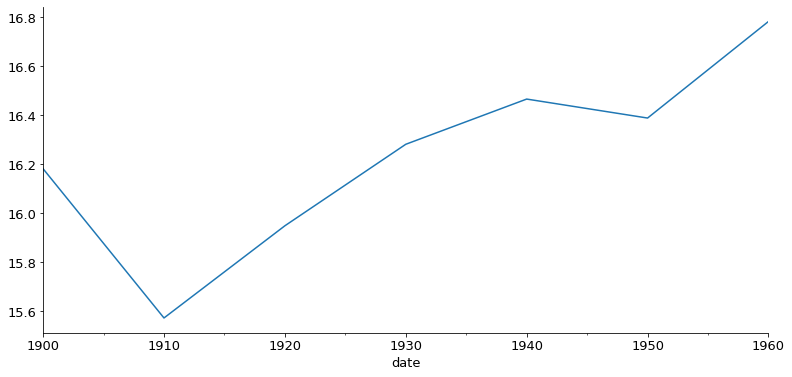

In [31]:
y.resample('10Y').mean().plot()

Over decades, we can see an upward trend in the later parts of our data. 

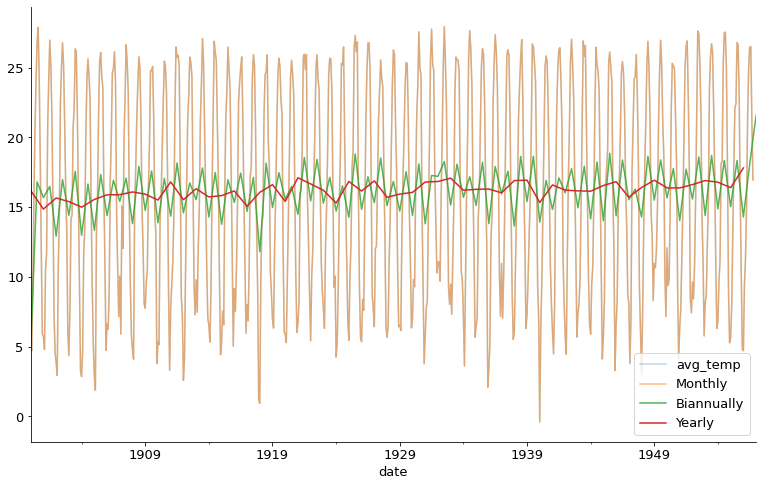

In [32]:
# average temperatures across various time periods

plt.figure(figsize=(13,8))
ax = y.plot(alpha=.3)
y.resample('M').mean().plot(ax=ax, alpha=.5, label='Monthly')
y.resample('6M').mean().plot(ax=ax, alpha=.8, label='Biannually')
y.resample('Y').mean().plot(ax=ax, label='Yearly')
ax.legend()
plt.show()

[Text(0.5, 1.0, 'Average Temperature Over Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temperature')]

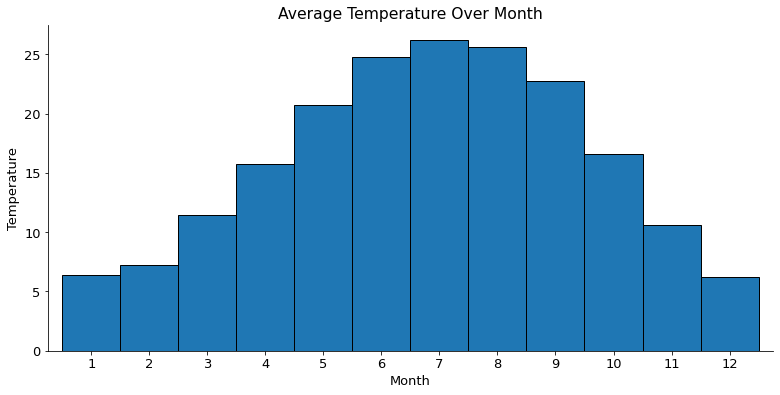

In [33]:
# average temperatures by month but in a bar chart 
# Coldest months are at the beginning and end of the year 
# Warmest months are June, July and August

ax = y.groupby(y.index.month).mean().plot.bar(width=1,ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature Over Month', xlabel='Month',ylabel='Temperature')

[Text(0.5, 0, 't'), Text(0, 0.5, 't+1')]

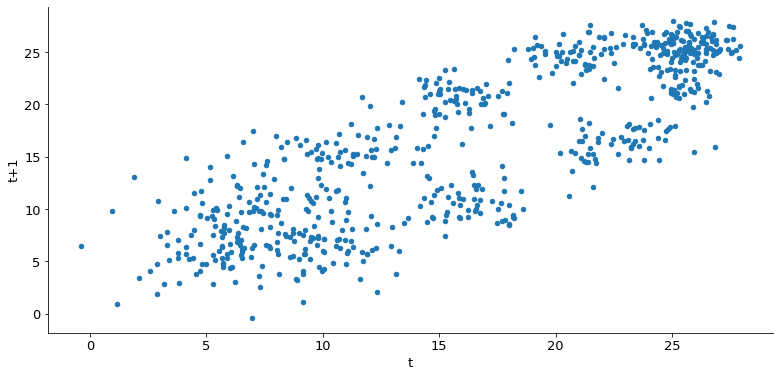

In [34]:
# lag is pretty good at guessing the next month

train['y(t+1)']=train.avg_temp.shift(-1)
ax=train.plot.scatter(x='avg_temp', y='y(t+1)')
ax.set(xlabel='t',ylabel='t+1')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

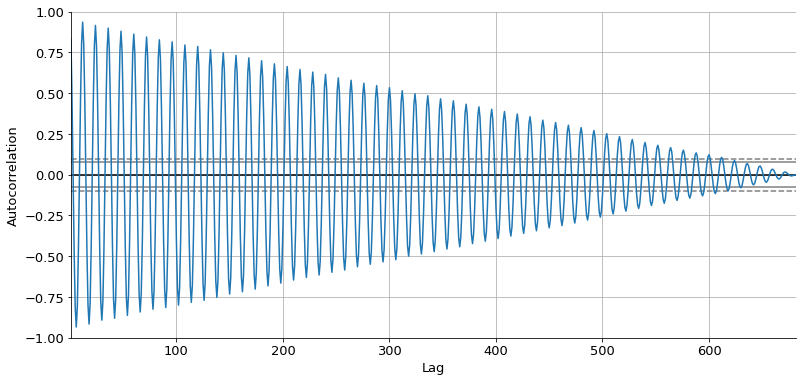

In [35]:
# auto correlation month

pd.plotting.autocorrelation_plot(train.avg_temp.resample('M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

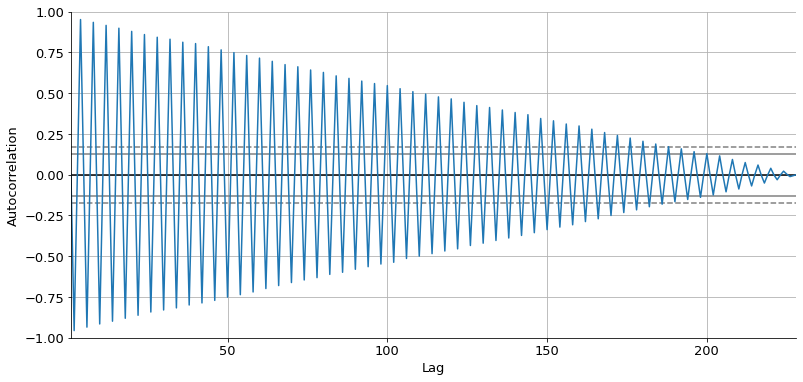

In [36]:
# auto correlation 3 month

pd.plotting.autocorrelation_plot(train.avg_temp.resample('3M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

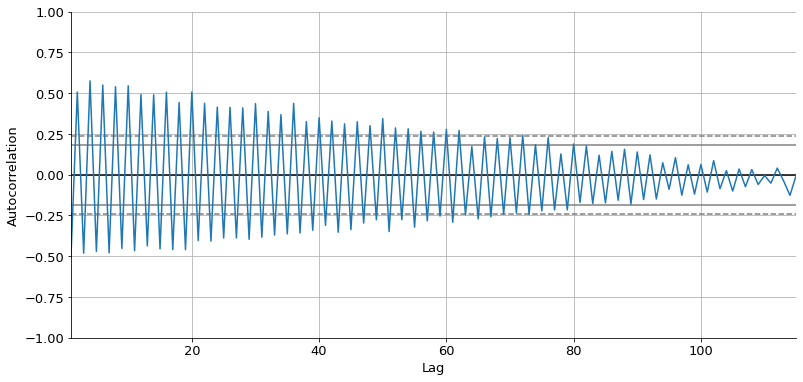

In [37]:
# auto correlation 6 month

pd.plotting.autocorrelation_plot(train.avg_temp.resample('6M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

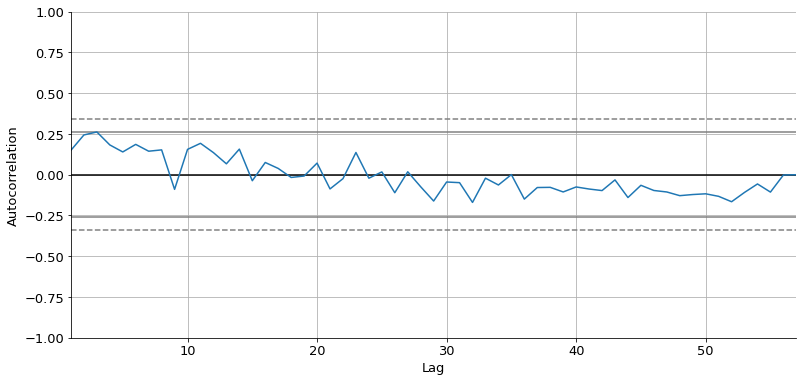

In [38]:
# auto correlation year

pd.plotting.autocorrelation_plot(train.avg_temp.resample('Y').mean())

In [39]:
# drop from our train

train = train.drop(columns=['y(t+1)'])

Takeaways:
   - Upward trend in temperature over time, lots of cycles within the year.
   - Easier to tell trends when sampled over longer periods of time
   - Whether resampling by month or multi-months there is clear correlation at peaks and valleys of the seasonal cycle

## Modeling

In [40]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    '''
    make a prediction column
    '''
    yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

    return yhat_df

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [41]:
# create an empty dataframe to store model type, our avg_temp, and its rmse

eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


### Last Observed Value

In [42]:
# the last observed value

temp=train['avg_temp'][-1:][0]
temp

16.941

In [43]:
# predictions based on last observed value

yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
1956-11-01,16.941
1956-12-01,16.941
1957-01-01,16.941
1957-02-01,16.941
1957-03-01,16.941


avg_temp -- RMSE: 8


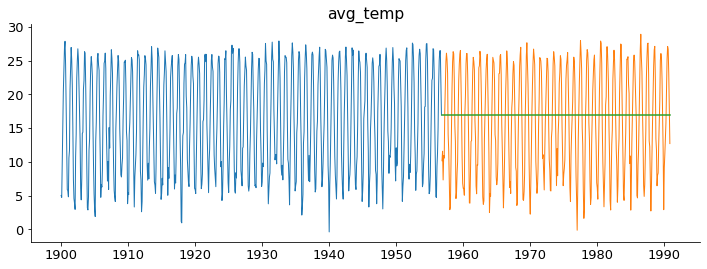

In [44]:
plot_and_eval('avg_temp')

In [45]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0


### Simple Average

In [46]:
# compute simple average/the mean of avergae temperatures

temp = round(train['avg_temp'].mean(),2)
temp

16.2

In [47]:
# predictions with simple average

yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
1956-11-01,16.2
1956-12-01,16.2
1957-01-01,16.2
1957-02-01,16.2
1957-03-01,16.2


avg_temp -- RMSE: 8


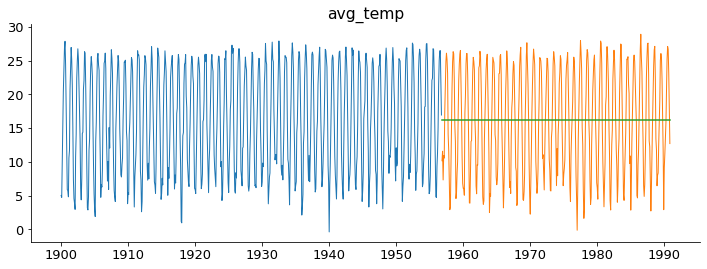

In [48]:
# visualize simple average predictions

plot_and_eval('avg_temp')

In [49]:
# append our simple averages RMSE to our evaluation dataframe

eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0


### Moving Average

In [50]:
# Rolling average of 3 months 

period = 3

temp = round(train['avg_temp'].rolling(period).mean()[-1],2)
print(temp)

21.57


In [51]:
yhat_df = make_predictions()
yhat_df.head(2)

,avg_temp
date,
1956-11-01,21.57
1956-12-01,21.57


avg_temp -- RMSE: 9


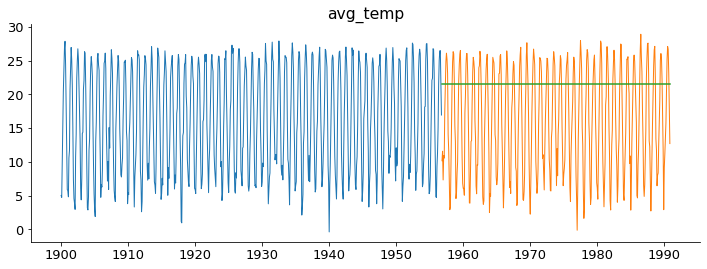

In [52]:
# visualize the rolling average of 3 months

plot_and_eval('avg_temp')

In [53]:
eval_df = append_eval_df(model_type = '3 month_moving_avg', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
2,3 month_moving_avg,avg_temp,9.0


In [54]:
# let's test out 6 months, a year, a year and a half, 2 years, and 3 years for moving averages

periods = [6, 12, 18, 24, 36]

for p in periods: 
    temp = round(train['avg_temp'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [55]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
2,3 month_moving_avg,avg_temp,9.0
3,6month_moving_avg,avg_temp,10.0
4,12month_moving_avg,avg_temp,8.0
5,18month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0


In [56]:
# similar results, let's keep going

min_temp_rmse = eval_df[eval_df.target_var=='avg_temp']['rmse'].min()

eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
4,12month_moving_avg,avg_temp,8.0
5,18month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0


### Holt's

In [57]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=0.1,
                      smoothing_slope = 0.1,
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [58]:
# dont think model is going to help much

yhat_df

,avg_temp
date,
1956-11-01,18.33
1956-12-01,18.51
1957-01-01,18.68
1957-02-01,18.86
1957-03-01,19.03
...,...
1990-07-01,88.94
1990-08-01,89.11
1990-09-01,89.29


avg_temp -- RMSE: 44


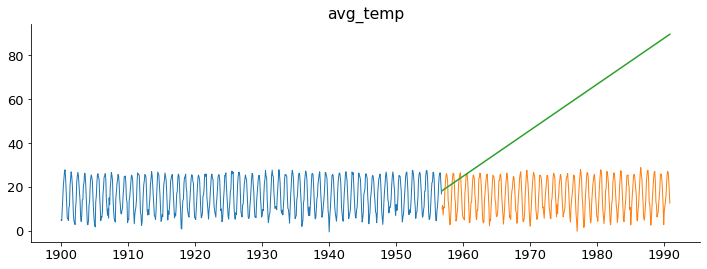

In [59]:
# visual

plot_and_eval('avg_temp')

In [60]:
# let's add it to the evaluation dataframe

eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
4,12month_moving_avg,avg_temp,8.0
5,18month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0
2,3 month_moving_avg,avg_temp,9.0
3,6month_moving_avg,avg_temp,10.0
8,holts_.1,avg_temp,44.0


In [61]:
# still a tie

eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
4,12month_moving_avg,avg_temp,8.0
5,18month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0


### Based on Cycle

In [62]:
# last few years of data, going to use them as my train, validate, and test

train = df[:'2010']
validate = df['2011']
test = df['2012']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(1332, 1)
(12, 1)
(12, 1)


,avg_temp
date,
2010-08-01,27.520
2010-09-01,24.647
2010-10-01,17.299
2010-11-01,11.359
2010-12-01,2.509


In [63]:
# our prediction will be a year added to train (2010)

yhat_df = train['2010'] + train.diff(12).mean()

In [64]:
# prediction vs actual value

pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp
date,
2010-01-01,3.713053
2011-01-01,3.735000


In [65]:
# set the indexes to each other

yhat_df.index = validate.index

avg_temp -- RMSE: 3


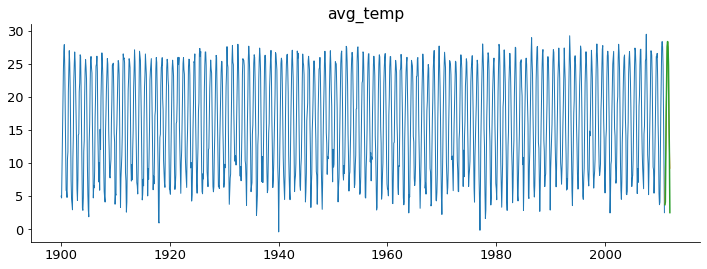

In [66]:
# visualize predictions for 2011 based off previous year cycle

for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [67]:
# let's see our evaluations

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
2,3 month_moving_avg,avg_temp,9.0
3,6month_moving_avg,avg_temp,10.0
4,12month_moving_avg,avg_temp,8.0
5,18month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0
8,holts_.1,avg_temp,44.0
9,previous_year,avg_temp,3.0


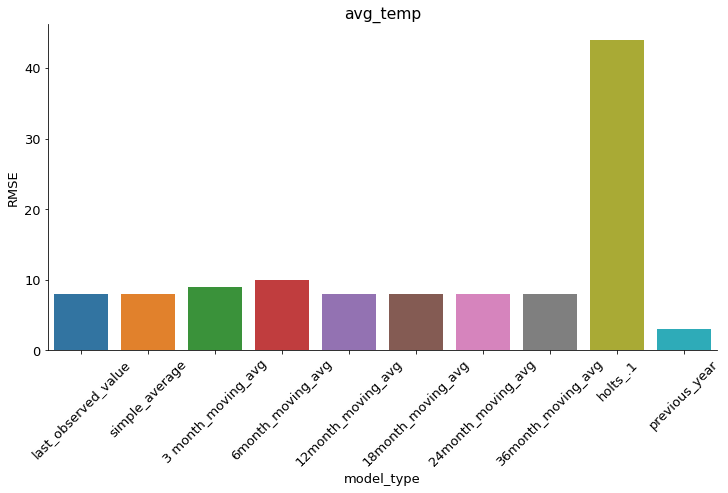

In [68]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [69]:
# predicting 2012

yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [70]:
# the rmse of the average temperature for our test

rmse_temp = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_temp']))

In [71]:
print('rmse-temp: ', rmse_temp)

rmse-temp:  2.23695197544303


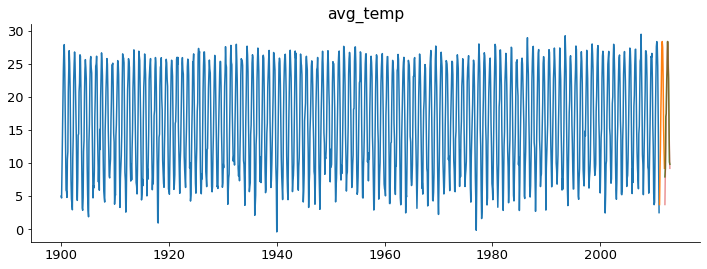

In [72]:
# look at final plot for predictions of 2012

for col in train.columns:
    final_plot(col)

In [73]:
# what if we predict 2013?

yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

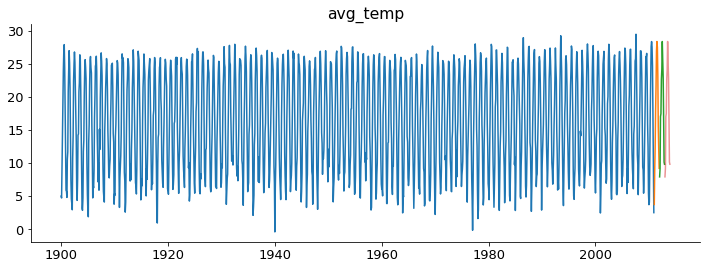

In [74]:
# final plot with prediction of 2013

final_plot(col)

# Conclusion:
 
**Key Findings, Takeaways, & Next Steps:**
 
 - Most of the models had a similar RMSE scores
 - Using the previous year's cycle had the lowest RMSE score, it worked better than using last observed value, simple average, moving average, and Holt's.
 - Using previous year's cycle for test, I ended with an RMSE of 2.2
 
 - **With more time:**
     - I'd like to look more into seasons
     - Look to see if global or local events lead to the dramatic changes in certain years
     - Make more models to test with using other features
     - See what changes in results would happen if I started my timeline further back
     - Look at other time series models
